# **Modelling**

In [ ]:
import os
import glob
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from google.colab import drive
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score,accuracy_score,f1_score,precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix   
from sklearn.preprocessing import MinMaxScaler                          
import numpy as np
from sklearn import metrics
from sklearn import tree

In [ ]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
working_dir = "/content/drive/MyDrive/KDD Project"

In [ ]:
stroke_pf = pd.read_csv(working_dir + '/healthcare-dataset-stroke-data.csv')

### **Data Preprocessing**

**Handling Missing Values**

In [ ]:
#bmi feature has null values
stroke_pf.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [ ]:
#drop all the rows having unknown value in smoking status feature
unknown_index = stroke_pf[stroke_pf['smoking_status'] =='Unknown'].index
stroke_pf = stroke_pf.drop(unknown_index)

In [ ]:
#drop 'other' value in gender feature
other_index = stroke_pf[stroke_pf['gender'] =='Other'].index
stroke_pf = stroke_pf.drop(other_index)

In [ ]:
# calculating median for bmi values gender wise 
stroke_pf.groupby(['gender'])['bmi'].agg(['median'])

,median
gender,
Female,28.7
Male,29.5


In [ ]:
#update null bmi values with median values computed above
F_missing_bmi_index = stroke_pf[(stroke_pf.gender == 'Female') & (stroke_pf.bmi.isna())].index
stroke_pf.loc[F_missing_bmi_index, 'bmi'] = 28.7

M_missing_bmi_index = stroke_pf[(stroke_pf.gender == 'Male') & (stroke_pf.bmi.isna())].index
stroke_pf.loc[M_missing_bmi_index, 'bmi'] = 29.5


**Handling Outliers**

In [ ]:
stroke_pf = stroke_pf.loc[~(stroke_pf.bmi>60)]
stroke_pf.shape

(3556, 12)

**Label Encoding**

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
stroke_pf['smoking_status'] = labelencoder.fit_transform(stroke_pf['smoking_status'])
stroke_pf['gender'] = labelencoder.fit_transform(stroke_pf['gender'])
stroke_pf['ever_married'] = labelencoder.fit_transform(stroke_pf['ever_married'])
stroke_pf['work_type'] = labelencoder.fit_transform(stroke_pf['work_type'])
stroke_pf['Residence_type'] = labelencoder.fit_transform(stroke_pf['Residence_type'])
stroke_pf['Residence_type'] = labelencoder.fit_transform(stroke_pf['Residence_type'])
stroke_pf.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67.0,0,1,1,2,1,228.69,36.6,0,1
1,51676,0,61.0,0,0,1,3,0,202.21,28.7,1,1
2,31112,1,80.0,0,1,1,2,0,105.92,32.5,1,1
3,60182,0,49.0,0,0,1,2,1,171.23,34.4,2,1
4,1665,0,79.0,1,0,1,3,0,174.12,24.0,1,1


**Original Data**



*   We tried to apply logistic regression on the data before performing undersampling and oversampling and noticed that our model has poor performance.


*   So, our next steps would be to perform undersampling and oversampling and check which methods best suite our dataset.





In [ ]:
def logisticReg(X_train, X_test, y_train, y_test):
  lr = LogisticRegression(class_weight = 'balanced')
  lr.fit(X_train,y_train)
  y_pred = lr.predict(X_test)
  
  plot_confusion_matrix(lr, X_test,y_test) 
  y_pred = lr.predict(X_test)

  print(f"Training Accuracy.: {lr.score(X_train, y_train)*100:.2f}%")
  print(f"Test Accuracy.: {lr.score(X_test, y_test)*100:.2f}%")
  print(f"Recall score.: {recall_score(y_test,y_pred)*100:.2f}%")
  print(f"Precision score.: {precision_score(y_test,y_pred) *100:.2f}%")
  print(f"F1 score .: {f1_score(y_test,y_pred)*100:.2f}%")
  
  

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.

Training Accuracy.: 71.94%
Test Accuracy.: 68.54%
Recall score.: 83.33%
Precision score.: 12.10%
F1 score .: 21.13%


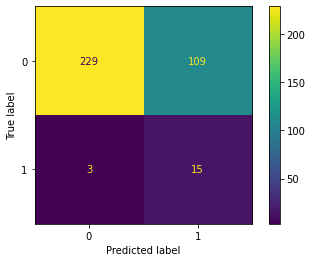

In [ ]:
X = stroke_pf.loc[:,~stroke_pf.columns.isin(['stroke','id'])]
y = stroke_pf.loc[:,stroke_pf.columns == 'stroke']
X_train_orignal, X_test_original, y_train_original, y_test_original = train_test_split(X,y,test_size = 0.1, random_state = 0)
logisticReg(X_train_orignal, X_test_original, y_train_original, y_test_original)

### **Data Preparation for Modeling**

In [ ]:

print(stroke_pf["stroke"].value_counts())

0    3354
1     202
Name: stroke, dtype: int64


**1. Handling Imbalanced Data**

From the graph below, we can find that the stroke prediction is highly imbalanced towards predicting the preson has low chnace of getting stroke.As a result, in order to get an efficient model, this unbalanced data must be dealt with first. The method of under-sampling is employed for this purpose.

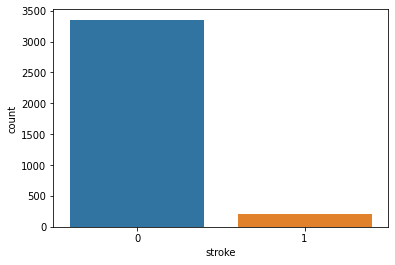

In [ ]:
sns.countplot(x=stroke_pf.stroke, data=stroke_pf)

**UnderSampling**

Undersampling equalizes the data by undersampling the majority class to match the minority class. In this scenario, the class with the value "0" is undersampled in comparison to the class with the value "1." The final dataset will include 249 rows with value '0' and 249 rows with value '1' after undersampling.

In [ ]:
# displays count of stroke 
# stroke = 0 -> person doesnot get stroke
# stroke = 1 -> indicates person getting stroke
stroke = len(stroke_pf[stroke_pf['stroke'] == 1])
print("stroke ",stroke)
no_stroke = len(stroke_pf[stroke_pf['stroke'] == 0])
print("no stroke ",no_stroke)

stroke  202
no stroke  3354


In [ ]:
# performing undersampling on data
no_stroke_indices = stroke_pf[stroke_pf['stroke'] == 0].index
random_indices = np.random.choice(no_stroke_indices,stroke, replace=False)
print("no stroke ",len(random_indices))
stroke_indices = stroke_pf[stroke_pf['stroke'] == 1].index
print("stroke ",len(stroke_indices))

under_sample_indices = np.concatenate([stroke_indices,random_indices])
print("After undersample, Total size of dataset =",len(under_sample_indices))
under_sample = stroke_pf.loc[under_sample_indices]

no stroke  202
stroke  202
After undersample, Total size of dataset = 404


In [ ]:
under_sample.drop(columns=['id'])

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.6,0,1
1,0,61.0,0,0,1,3,0,202.21,28.7,1,1
2,1,80.0,0,1,1,2,0,105.92,32.5,1,1
3,0,49.0,0,0,1,2,1,171.23,34.4,2,1
4,0,79.0,1,0,1,3,0,174.12,24.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
4816,0,54.0,1,0,0,0,1,182.22,32.6,0,0
2334,1,73.0,0,0,0,0,0,79.59,31.4,2,0
836,0,51.0,0,0,0,2,1,110.76,24.7,0,0
1410,0,52.0,0,0,1,2,1,107.29,28.1,1,0


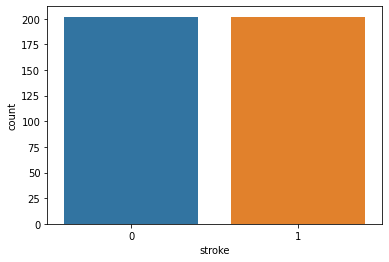

In [ ]:
#plot dataset after undersampling
sns.countplot(x=under_sample.stroke, data=under_sample)

In [ ]:
#splitting the data into input and output columns
X_under = under_sample.loc[:,~under_sample.columns.isin(['stroke','id'])]
y_under = under_sample.loc[:,under_sample.columns == 'stroke']


**Scaling the data**

In [ ]:
scaler = MinMaxScaler()
X_under[['avg_glucose_level','bmi']] = scaler.fit_transform(X_under[['avg_glucose_level','bmi']])
X_under = pd.get_dummies(X_under, drop_first=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [ ]:
#split the data into train and test set
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_under,y_under,test_size = 0.1, random_state = 0)

## **Modeling**
We comparing the results of three different models on our dataset.

1.   Logistic Regression
2.   Decision Trees
3.   Random Forest


**Logistic Regression**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.

Training Accuracy.: 72.45%
Test Accuracy.: 85.37%
Recall score.: 90.00%
Precision score.: 81.82%
F1 score .: 85.71%


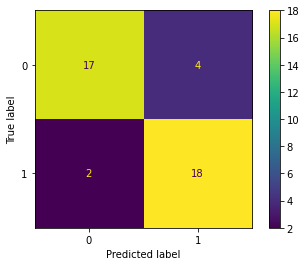

In [ ]:
logisticReg(X_train_under, X_test_under, y_train_under, y_test_under)

**Decision Tree**

In [ ]:
def decisionTree(X_train, X_test, y_train, y_test):
  X_train, X_test, y_train, y_test = train_test_split(X_train,y_train,test_size = 0.3, random_state = 0)
  clf = tree.DecisionTreeClassifier()
  clf = clf.fit(X_train, y_train)

  print(f"Train Acc.: {clf.score(X_train, y_train)*100:.2f}%")
  print(f"Test Acc.: {clf.score(X_test, y_test)*100:.2f}%")

  y_pred = clf.predict(X_test)
  print(f"Recall .: {recall_score(y_test,y_pred)*100:.2f}%")
  print(f"Precision.: {precision_score(y_test,y_pred)*100:.2f}%")
  print(f"F1 score.: {f1_score(y_test,y_pred)*100:.2f}%")
  plot_confusion_matrix(clf, X_test,y_test)

Train Acc.: 100.00%
Test Acc.: 63.30%
Recall .: 66.04%
Precision.: 61.40%
F1 score.: 63.64%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


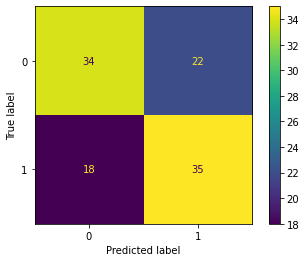

In [ ]:
decisionTree(X_train_under, X_test_under, y_train_under, y_test_under)

**Random Forest**

In [ ]:
def random_forest(X_train, X_test, y_train, y_test):
    
    random_forest = RandomForestClassifier(max_depth=11, min_samples_split=4, random_state=10)
    random_forest.fit(X_train, y_train)
    print(f"Train Acc.: {random_forest.score(X_train, y_train)*100:.2f}%")
    print(f"Test Acc.: {random_forest.score(X_test, y_test)*100:.2f}%")
    y_pred = random_forest.predict(X_test)
    
    print(f"Recall .: {recall_score(y_test,y_pred)*100:.2f}%")
    print(f"Precision.: {precision_score(y_test,y_pred)*100:.2f}%")
    print(f"F1 score.: {f1_score(y_test,y_pred)*100:.2f}%")
    plot_confusion_matrix(random_forest, X_test,y_test)
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Train Acc.: 98.07%
Test Acc.: 73.17%
Recall .: 75.00%
Precision.: 71.43%
F1 score.: 73.17%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


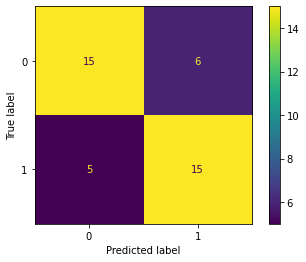

In [ ]:
random_forest(X_train_under, X_test_under, y_train_under, y_test_under)

While using undersampling, our model suffers with overfitting in all the three cases. So, we tried to solve it using oversampling.

**over sample**

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

In [ ]:
X = pd.get_dummies(X, drop_first=True)
sm_scaled = SMOTE(sampling_strategy='minority')
X_sm1, y_sm1 = sm_scaled.fit_resample(X, y)

X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X_sm1, y_sm1, test_size=0.2, stratify = y_sm1, random_state = 10)

X_train_over = scaler.fit_transform(X_train_over)
X_test_over = scaler.fit_transform(X_test_over)


**Logistic Regression**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Training Accuracy.: 78.64%
Test Accuracy.: 79.36%
Recall score.: 81.67%
Precision score.: 78.06%
F1 score .: 79.83%


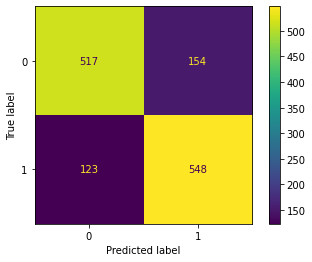

In [ ]:
logisticReg(X_train_over, X_test_over, y_train_over, y_test_over)

**Random Forest**

In [ ]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(X_sm1, y_sm1, test_size=0.3, stratify = y_sm1, random_state = 10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Train Acc.: 95.57%
Test Acc.: 91.21%
Recall .: 93.15%
Precision.: 89.67%
F1 score.: 91.38%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


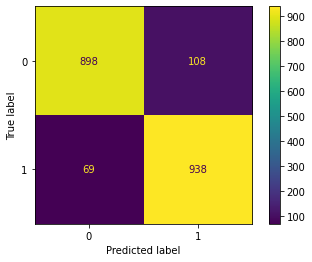

In [ ]:
random_forest(X_train4, X_test4, y_train4, y_test4)

**Decision Tree**

In [ ]:
X = pd.get_dummies(X, drop_first=True)
sm_scaled = SMOTE(sampling_strategy='minority')
X_sm1, y_sm1 = sm_scaled.fit_resample(X, y)
X_train4, X_test4, y_train4, y_test4 = train_test_split(X_sm1, y_sm1, test_size=0.3, stratify = y_sm1, random_state = 10)

X_train4 = scaler.fit_transform(X_train4)
X_test4 = scaler.fit_transform(X_test4)

Train Acc.: 100.00%
Test Acc.: 90.16%
Recall .: 91.80%
Precision.: 88.89%
F1 score.: 90.32%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


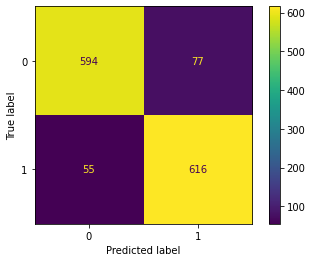

In [ ]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(X_sm1, y_sm1, test_size=0.2, stratify = y_sm1, random_state = 10)
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train4, y_train4)

print(f"Train Acc.: {clf.score(X_train4, y_train4)*100:.2f}%")
print(f"Test Acc.: {clf.score(X_test4, y_test4)*100:.2f}%")

y_pred4 = clf.predict(X_test4)
print(f"Recall .: {recall_score(y_test4,y_pred4)*100:.2f}%")
print(f"Precision.: {precision_score(y_test4,y_pred4)*100:.2f}%")
print(f"F1 score.: {f1_score(y_test4,y_pred4)*100:.2f}%")

plot_confusion_matrix(clf, X_test4,y_test4) 


## **Evalution**

We are evaluating the performance of our model using different metrics
1. Accuracy 
2. Precision
The metrics for each of the model can be found in Modeling section and in the results section.
We are also displaying a confusion matrix for each of the model

## **Results**

We found best results while using the decision trees and the random forest models using oversampling data.

#### **Under Sampling** 

|                     | Test Accuracy | Train Accuracy | F1 Score |
|---------------------|:-------------:|:--------------:|:--------:|
| Logistic Regression | 85.37         | 72.45          | 85.71    |
| Decision Tree       | 63.30         | 100            | 63.64    |
| Random Forest       | 73.17         | 98.07          | 73.17    |

#### **Over Sampling**


|                     | Test Accuracy | Train Accuracy | F1 Score |
|---------------------|:-------------:|:--------------:|----------|
| Logistic Regression | 79.36         | 78.64          | 79.83    |
| Decision Tree       |**90.16**         | **100**        | **90.32**    |
| Random Forest       | **91.21**         | **95.57**          | **91.38**    |


**References**

https://thesai.org/Downloads/Volume12No6/Paper_62-Analyzing_the_Performance_of_Stroke_Prediction.pdf